In [10]:
import numpy as np
import pandas as pd
import networkx as nx
import statistics as s
from itertools import product
import csv
from math import floor

In [7]:
def FCA(G, s, k, iteration):
    """Implements the Firefly Cellular Automata model

    Args:
        G (NetworkX Graph): Input graph to the model
        s (array): Current state
        k (int): k-color FCA
        iteration (int): number of iterations

    Returns:
        ret: states at each iteration
        synchronize: whether the system synchronizes at the final iteration
    """
    b = (k-1)//2 # Blinking color
    ret = s
    s_next = np.zeros(G.number_of_nodes())
    for h in range(iteration):
        if h != 0:
            s = s_next # Update to the newest state
            ret = np.vstack((ret, s_next))
        s_next = np.zeros(G.number_of_nodes())
        for i in range(G.number_of_nodes()):
            flag = False # True if inhibited by the blinking neighbor
            if s[i] > b:
                for j in range(G.number_of_nodes()):
                    if s[j] == b and list(G.nodes)[j] in list(G.adj[list(G.nodes)[i]]):
                        flag = True
                if flag:
                    s_next[i] = s[i]
                else:
                    s_next[i] = (s[i]+1)%k
            else:
                s_next[i] = (s[i]+1)%k
    
    synchronize = False
    if len(np.unique(ret[-1])) == 1 and iteration != 1:
        synchronize = True
        
    return ret, synchronize

In [8]:
#generate all possible different connected networks with n nodes
#https://matplotlib.org/matplotblog/posts/draw-all-graphs-of-n-nodes/
def make_graphs(n=2, i=None, j=None):
    """Make a graph recursively, by either including, or skipping each edge.

    Edges are given in lexicographical order by construction."""
    out = []
    if i is None: # First call

        out  = [[(0,1)]+r for r in make_graphs(n=n, i=0, j=1)]
    elif j<n-1:
        out += [[(i,j+1)]+r for r in make_graphs(n=n, i=i, j=j+1)]
        out += [          r for r in make_graphs(n=n, i=i, j=j+1)]
    elif i<n-1:
        out = make_graphs(n=n, i=i+1, j=i+1)
    else:
        out = [[]]
    return out

def perm(n, s=None):
    """All permutations of n elements."""
    if s is None: return perm(n, tuple(range(n)))
    if not s: return [[]]
    return [[i]+p for i in s for p in perm(n, tuple([k for k in s if k!=i]))]

def permute(g, n):
    """Create a set of all possible isomorphic codes for a graph,

    as nice hashable tuples. All edges are i<j, and sorted lexicographically."""
    ps = perm(n)
    out = set([])
    for p in ps:
        out.add(tuple(sorted([(p[i],p[j]) if p[i]<p[j]
                              else (p[j],p[i]) for i,j in g])))
    return list(out)

def connected(g):
    """Check if the graph is fully connected, with Union-Find."""
    nodes = set([i for e in g for i in e])
    roots = {node: node for node in nodes}

    def _root(node, depth=0):
        if node==roots[node]: return (node, depth)
        else: return _root(roots[node], depth+1)

    for i,j in g:
        ri,di = _root(i)
        rj,dj = _root(j)
        if ri==rj: continue
        if di<=dj: roots[ri] = rj
        else:      roots[rj] = ri
    return len(set([_root(node)[0] for node in nodes]))==1

def filter(gs, target_nv):
    """Filter all improper graphs: those with not enough nodes,

    those not fully connected, and those isomorphic to previously considered."""
    mem = set({})
    gs2 = []
    for g in gs:
        nv = len(set([i for e in g for i in e]))
        if nv != target_nv:
            continue
        if not connected(g):
            continue
        if tuple(g) not in mem:
            gs2.append(g)
            mem |= set(permute(g, target_nv))
    return gs2

In [9]:
#compute width to check the half-circle concentration
#from L2PSync repo
def width_compute(coloring, kappa):
    differences = [np.max(coloring) - np.min(coloring)]
    for j in range(1,kappa+1):
        shifted = (np.array(coloring) + j) % kappa
        differences.append(np.max(shifted) - np.min(shifted))
    return np.min(differences)

In [10]:
#FCA_iter: total iteration for the FCA model, used for label
#baseline_iter: the iteration for baseline model, usually less than FCA_iter
#num_edges, num_nodes, min_degree, max_degree, diameter, quartile_1, quartile_2, quartile_3, states, y, baseline_width
def FCA_datagen(num_nodes, kappa, FCA_iter, baseline_iter, file_name):
    #generate all possible permutation of color lists
    color_list = list(product(range(0, kappa), repeat=num_nodes))
    #list of all possible different networks with n nodes
    gs = make_graphs(num_nodes)
    gs = filter(gs, num_nodes) 
    
    #generate the toy dataset
    file = open(file_name, 'w+', newline ='')
    
    graph_list = [] #storing the order of graph in the generated dataset
    
    header = ["num_edges", "num_nodes", "min_degree", "max_degree", "diameter", "quartile_1", 
              "quartile_2", "quartile_3", "y", "baseline_width"]
    for i in range(baseline_iter):
        for j in range(num_nodes):
            header.append("s"+str(i+1)+"_"+str(j+1))
    
    with file:   
        write = csv.writer(file)
        
        write.writerow(header)
        for col in color_list:
            for i in gs:
                G = nx.Graph()
                G.add_edges_from(i)
                graph_list.append(i)

                num_edges = G.number_of_edges()
                min_degree = min(list(G.degree), key=lambda x:x[1])[1]
                max_degree = max(list(G.degree), key=lambda x:x[1])[1]
                diameter = nx.diameter(G)
                quartile_1 = s.quantiles(col, n=4)[0]
                quartile_2 = s.quantiles(col, n=4)[1]
                quartile_3 = s.quantiles(col, n=4)[2]

                sample = [num_edges, num_nodes, min_degree, max_degree, diameter, 
                           quartile_1, quartile_2, quartile_3]
                states, label = FCA(G, col, kappa, FCA_iter)

                width = width_compute(states[FCA_iter-1],kappa)
                y = False
                if(width < floor(kappa/2)): #half circle concentration
                    y = True
                sample.append(y)

                baseline_width = width_compute(states[baseline_iter-1],kappa)
                baseline = False
                if(baseline_width < floor(kappa/2)): #half circle concentration
                    baseline = True
                sample.append(baseline)
                
                for j in range(baseline_iter):
                    sample = sample+list(states[j])
                    
                write.writerow(sample)
    return graph_list

In [22]:
graph_list = FCA_datagen(6, 4, 30, 5, "toy.csv")

In [57]:
df=pd.read_csv("toy.csv")
df.drop('y', axis=1, inplace=True)
df.drop('baseline_width', axis=1, inplace=True)
y_pred_all = svc.predict(df) #use svm model to predict all samples
kappa = 4
num_nodes = 6
color_list = list(product(range(0, kappa), repeat=num_nodes)) #4096
    #list of all possible different networks with n nodes
gs = make_graphs(num_nodes)
gs = filter(gs, num_nodes) #112

df=pd.read_csv("toy.csv")
corr_pred = [0] * len(gs) #correct predictions
sync_perc = [0] * len(gs) #get the percentage of synchronization for 112 different graph structures
for i in range(len(color_list)):
    for j in range(len(gs)):
        corr_pred[j] += int(y_pred_all[i*len(gs)+j]==df.y[i*len(gs)+j])
        sync_perc[j] += int(df.y[i*len(gs)+j])
        
sort_index = np.argsort(corr_pred)

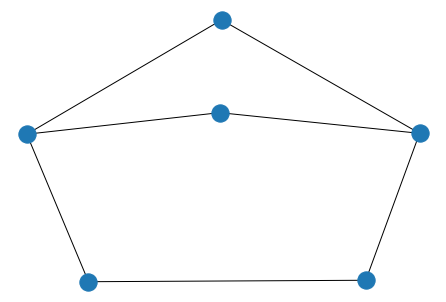

Correctly classified:  0.05810546875
Actual Synchronization: 0.97265625


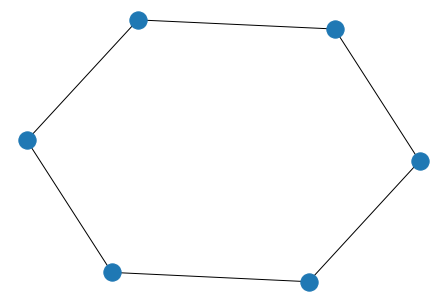

Correctly classified:  0.1611328125
Actual Synchronization: 0.8564453125


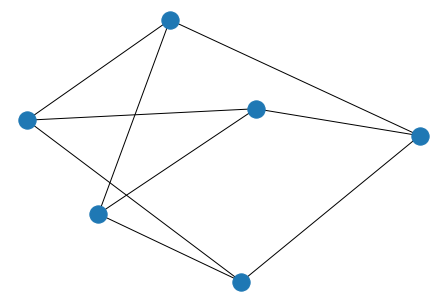

Correctly classified:  0.1630859375
Actual Synchronization: 0.982421875


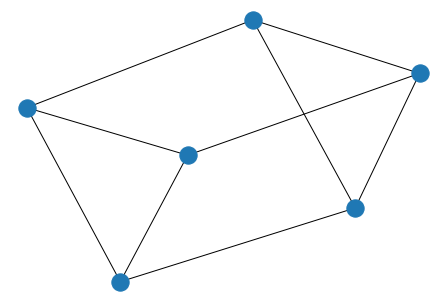

Correctly classified:  0.165283203125
Actual Synchronization: 0.9765625


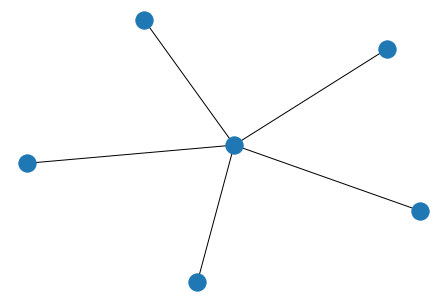

Correctly classified:  0.17138671875
Actual Synchronization: 0.8828125


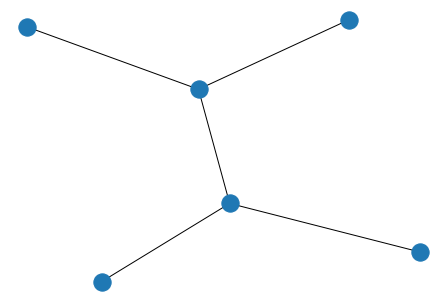

Correctly classified:  0.21044921875
Actual Synchronization: 1.0


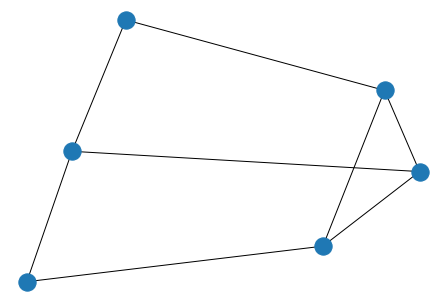

Correctly classified:  0.345947265625
Actual Synchronization: 1.0


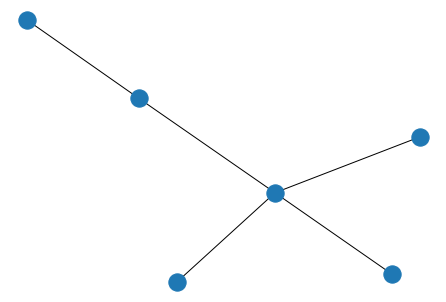

Correctly classified:  0.3779296875
Actual Synchronization: 0.958984375


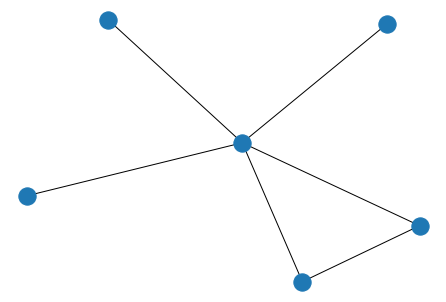

Correctly classified:  0.395263671875
Actual Synchronization: 0.953125


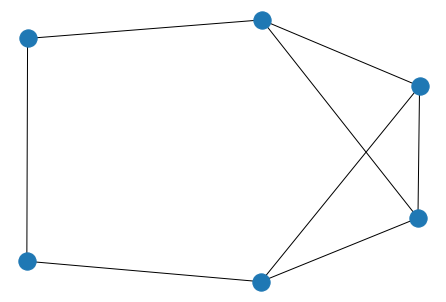

Correctly classified:  0.416015625
Actual Synchronization: 0.9453125


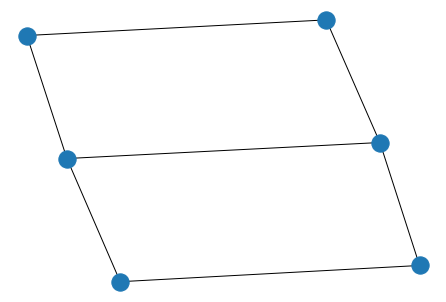

Correctly classified:  0.4521484375
Actual Synchronization: 1.0


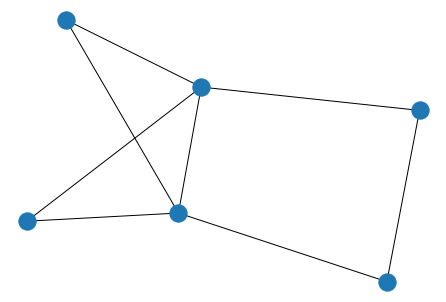

Correctly classified:  0.455810546875
Actual Synchronization: 1.0


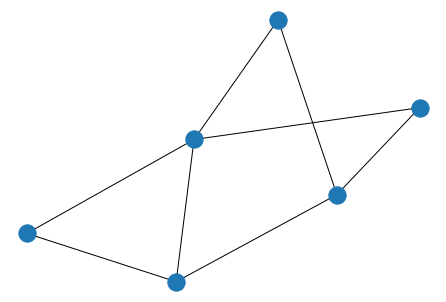

Correctly classified:  0.465087890625
Actual Synchronization: 1.0


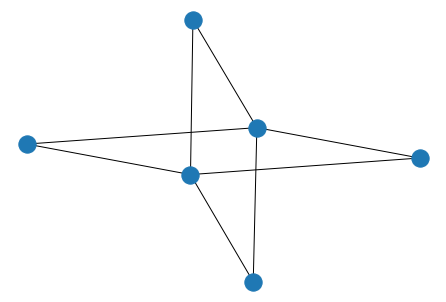

Correctly classified:  0.473388671875
Actual Synchronization: 0.9765625


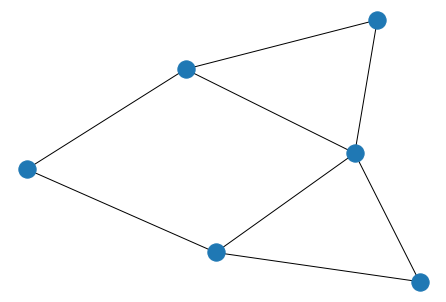

Correctly classified:  0.485107421875
Actual Synchronization: 1.0


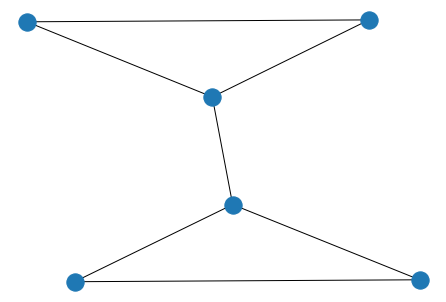

Correctly classified:  0.508056640625
Actual Synchronization: 1.0


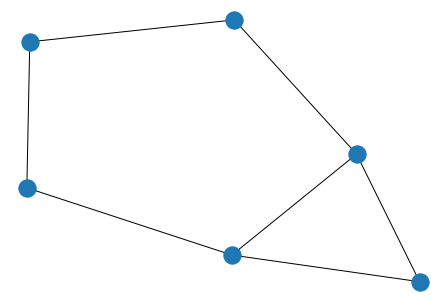

Correctly classified:  0.525634765625
Actual Synchronization: 0.93310546875


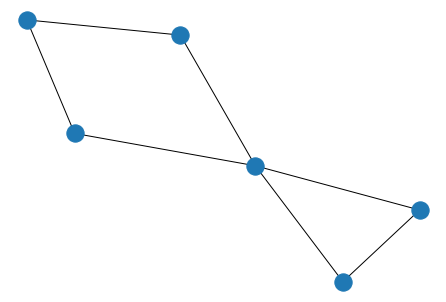

Correctly classified:  0.593505859375
Actual Synchronization: 1.0


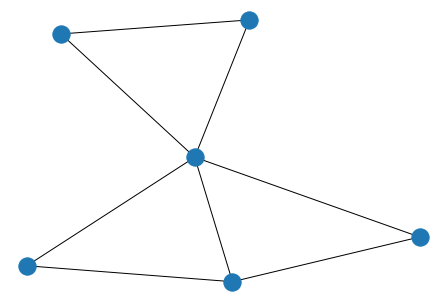

Correctly classified:  0.59423828125
Actual Synchronization: 1.0


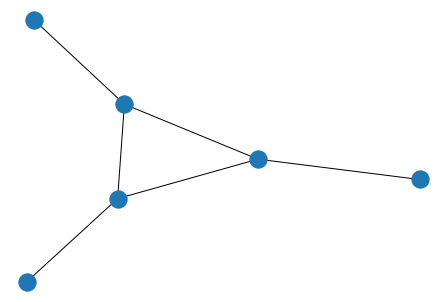

Correctly classified:  0.630126953125
Actual Synchronization: 1.0


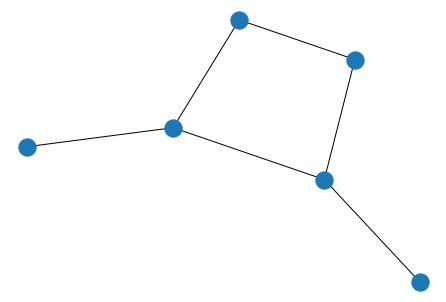

Correctly classified:  0.643798828125
Actual Synchronization: 1.0


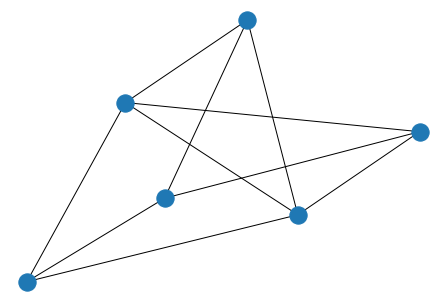

Correctly classified:  0.654052734375
Actual Synchronization: 1.0


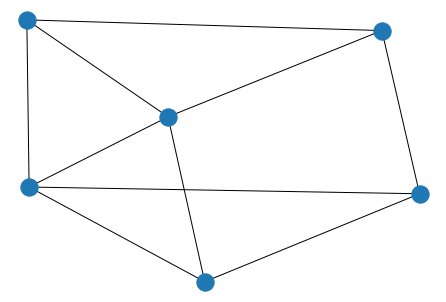

Correctly classified:  0.66552734375
Actual Synchronization: 1.0


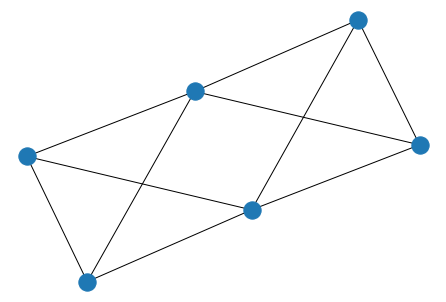

Correctly classified:  0.668212890625
Actual Synchronization: 1.0


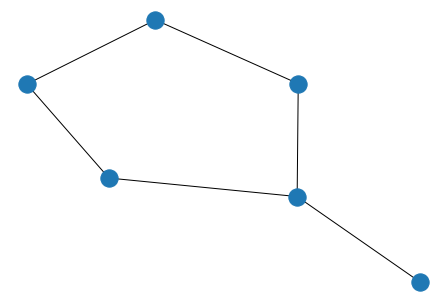

Correctly classified:  0.683837890625
Actual Synchronization: 0.93701171875


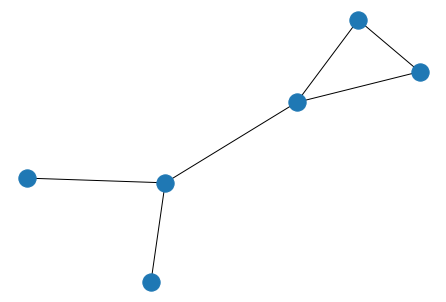

Correctly classified:  0.719482421875
Actual Synchronization: 1.0


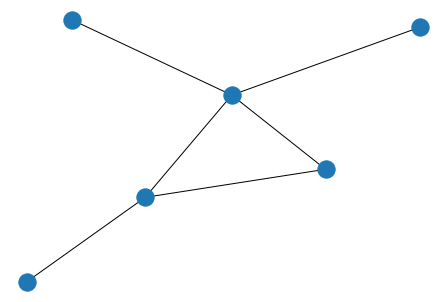

Correctly classified:  0.755126953125
Actual Synchronization: 1.0


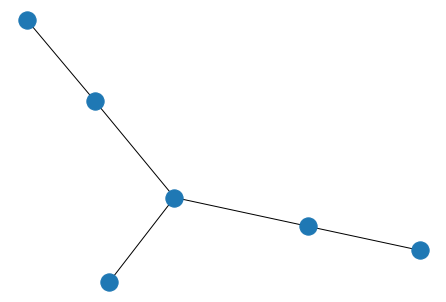

Correctly classified:  0.773193359375
Actual Synchronization: 1.0


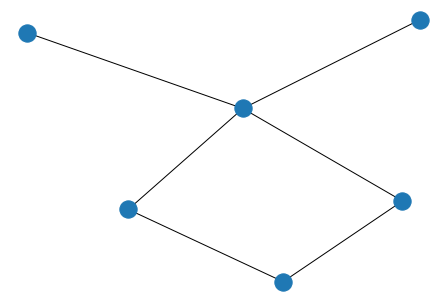

Correctly classified:  0.774169921875
Actual Synchronization: 1.0


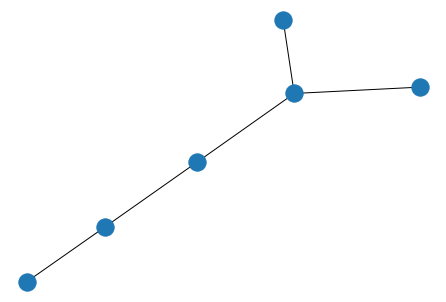

Correctly classified:  0.77880859375
Actual Synchronization: 1.0


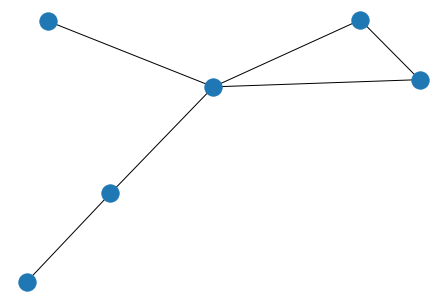

Correctly classified:  0.795166015625
Actual Synchronization: 1.0


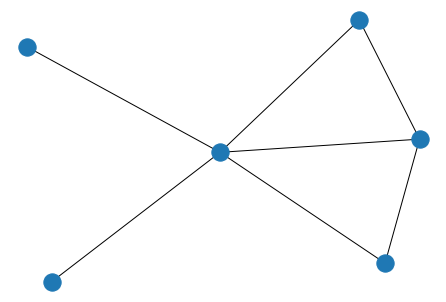

Correctly classified:  0.798828125
Actual Synchronization: 1.0


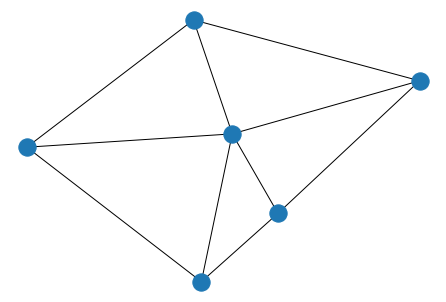

Correctly classified:  0.81787109375
Actual Synchronization: 0.9658203125


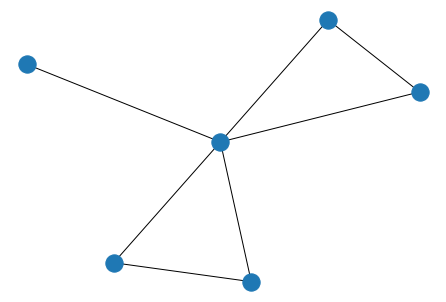

Correctly classified:  0.820556640625
Actual Synchronization: 1.0


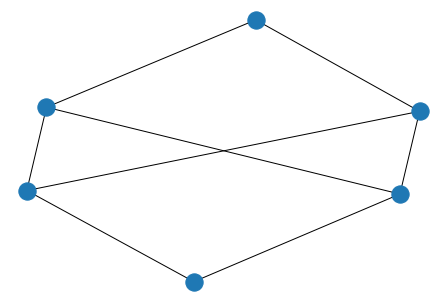

Correctly classified:  0.822265625
Actual Synchronization: 1.0


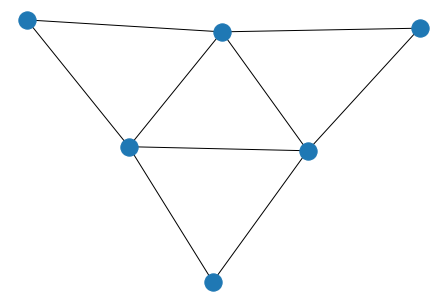

Correctly classified:  0.8232421875
Actual Synchronization: 0.9765625


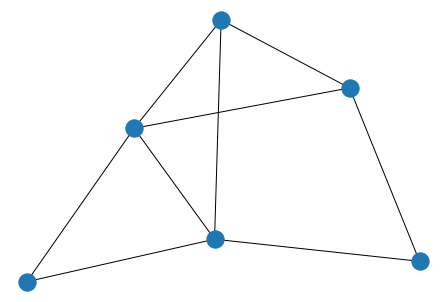

Correctly classified:  0.83544921875
Actual Synchronization: 1.0


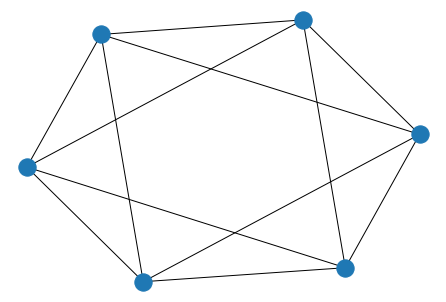

Correctly classified:  0.842041015625
Actual Synchronization: 1.0


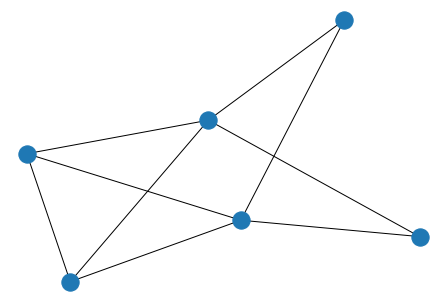

Correctly classified:  0.845458984375
Actual Synchronization: 1.0


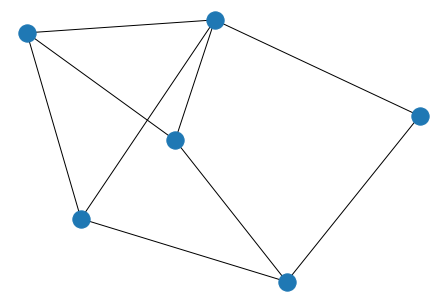

Correctly classified:  0.85107421875
Actual Synchronization: 1.0


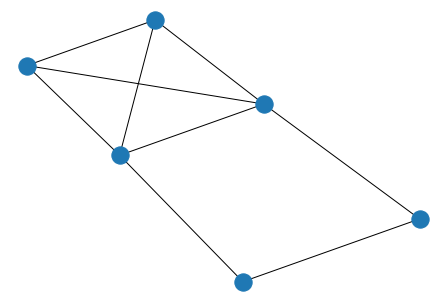

Correctly classified:  0.85498046875
Actual Synchronization: 1.0


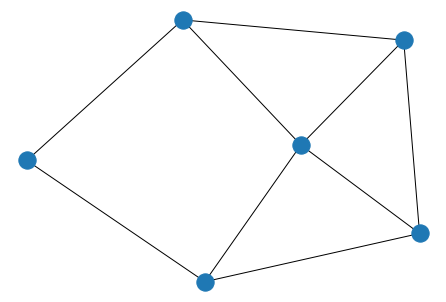

Correctly classified:  0.8583984375
Actual Synchronization: 1.0


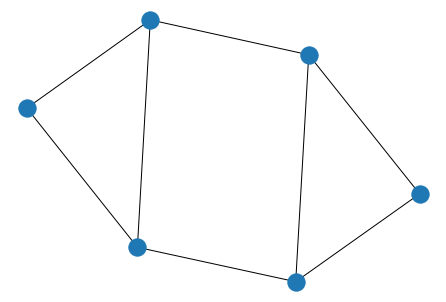

Correctly classified:  0.86279296875
Actual Synchronization: 1.0


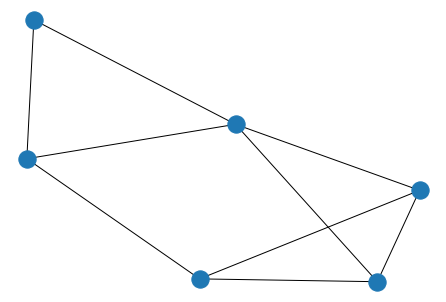

Correctly classified:  0.867431640625
Actual Synchronization: 1.0


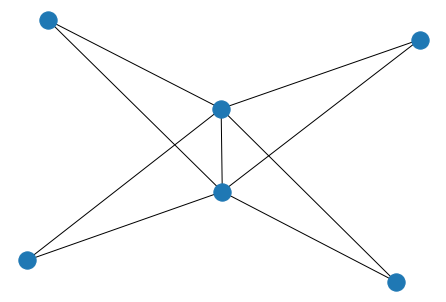

Correctly classified:  0.9169921875
Actual Synchronization: 0.9765625


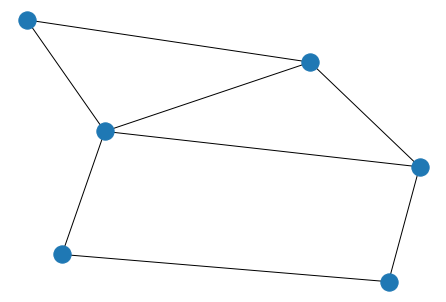

Correctly classified:  0.918212890625
Actual Synchronization: 1.0


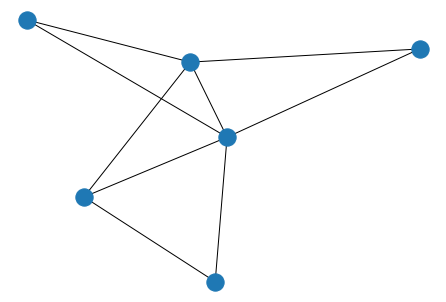

Correctly classified:  0.920654296875
Actual Synchronization: 1.0


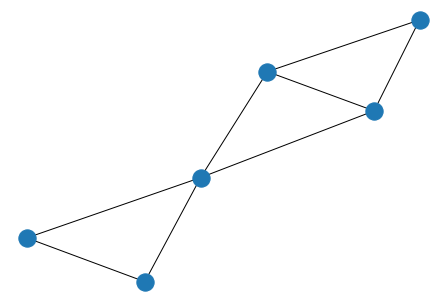

Correctly classified:  0.92431640625
Actual Synchronization: 1.0


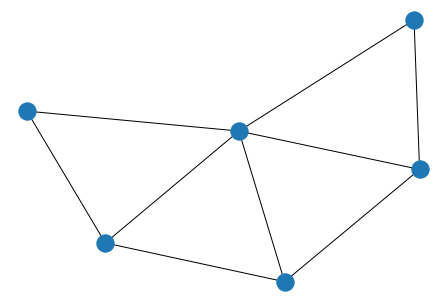

Correctly classified:  0.9375
Actual Synchronization: 1.0


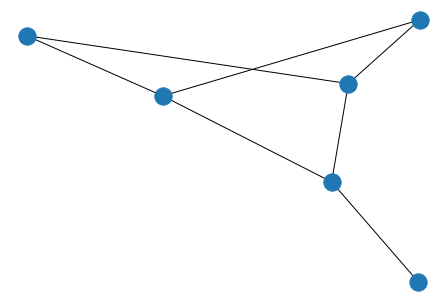

Correctly classified:  0.94873046875
Actual Synchronization: 1.0


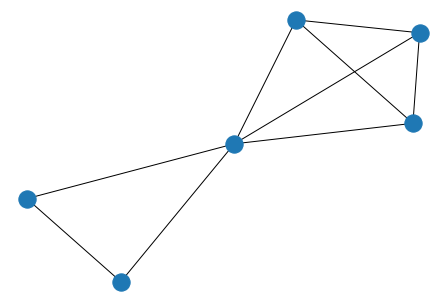

Correctly classified:  0.9501953125
Actual Synchronization: 1.0


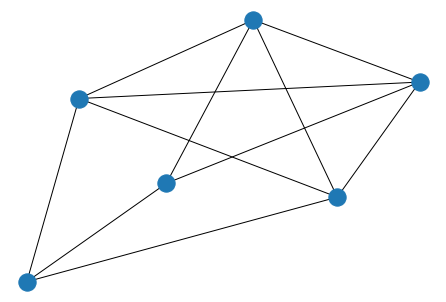

Correctly classified:  0.95263671875
Actual Synchronization: 1.0


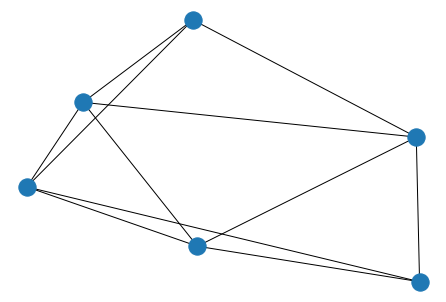

Correctly classified:  0.954833984375
Actual Synchronization: 1.0


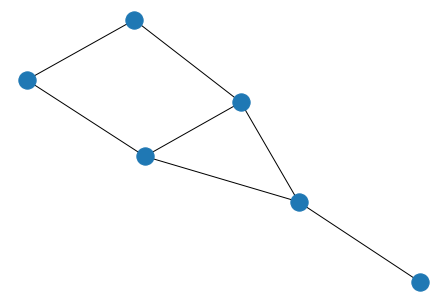

Correctly classified:  0.957763671875
Actual Synchronization: 1.0


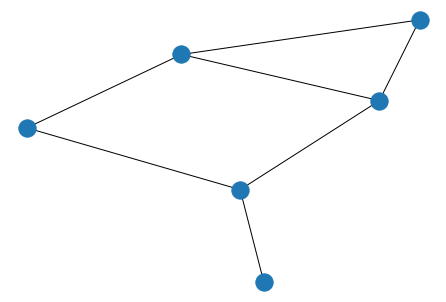

Correctly classified:  0.963134765625
Actual Synchronization: 1.0


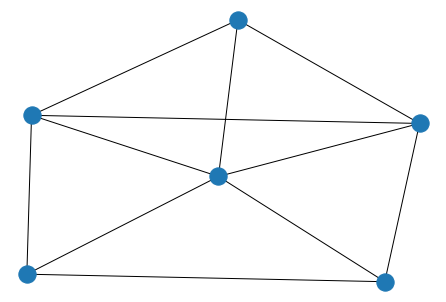

Correctly classified:  0.978759765625
Actual Synchronization: 1.0


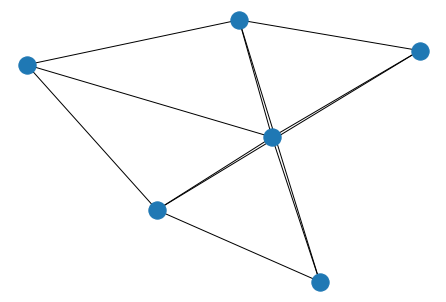

Correctly classified:  0.98046875
Actual Synchronization: 1.0


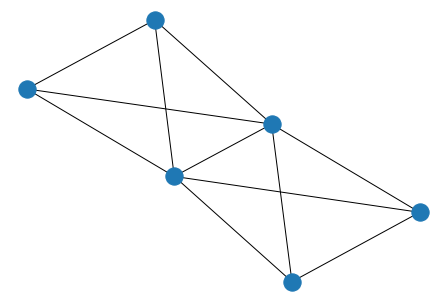

Correctly classified:  0.982666015625
Actual Synchronization: 1.0


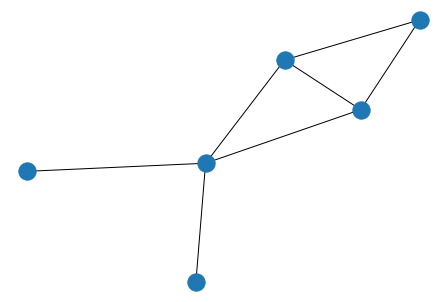

Correctly classified:  0.98486328125
Actual Synchronization: 1.0


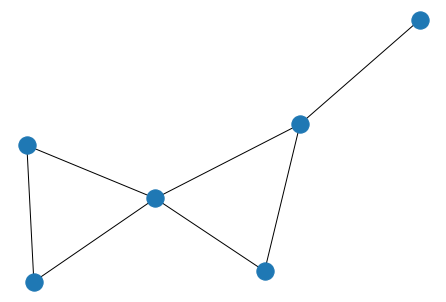

Correctly classified:  0.985107421875
Actual Synchronization: 1.0


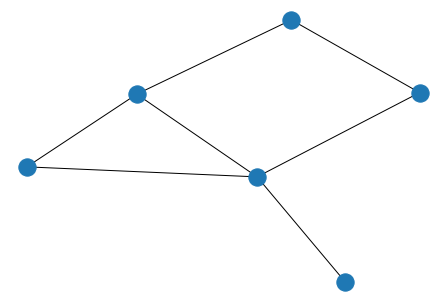

Correctly classified:  0.9853515625
Actual Synchronization: 1.0


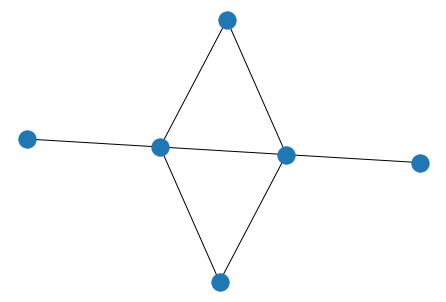

Correctly classified:  0.98583984375
Actual Synchronization: 1.0


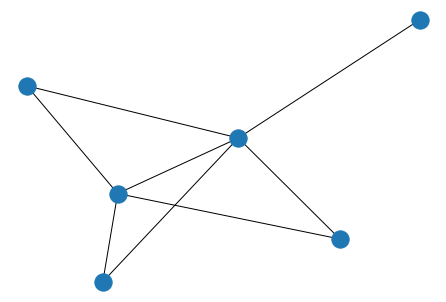

Correctly classified:  0.98583984375
Actual Synchronization: 1.0


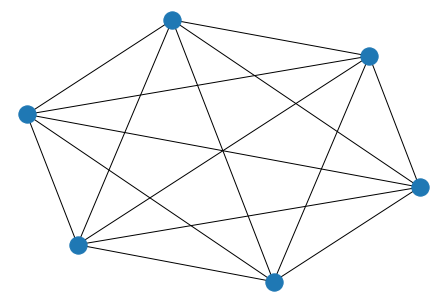

Correctly classified:  0.98583984375
Actual Synchronization: 1.0


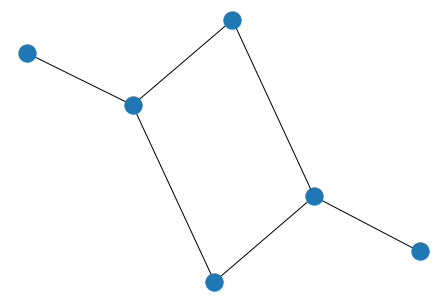

Correctly classified:  0.986083984375
Actual Synchronization: 1.0


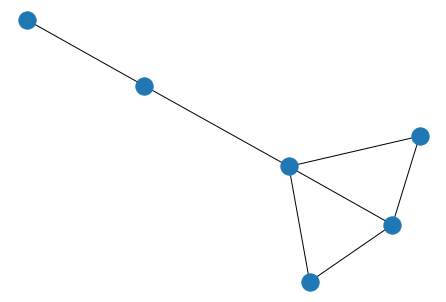

Correctly classified:  0.987060546875
Actual Synchronization: 1.0


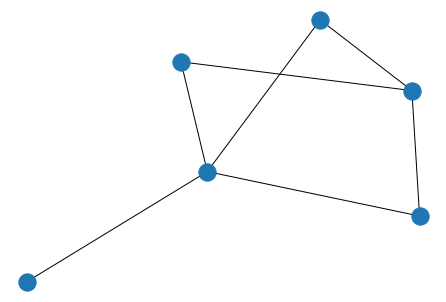

Correctly classified:  0.9873046875
Actual Synchronization: 1.0


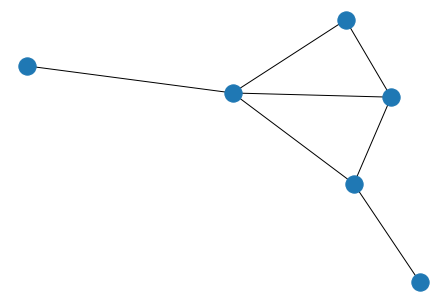

Correctly classified:  0.9873046875
Actual Synchronization: 1.0


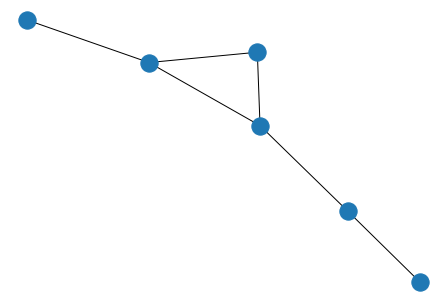

Correctly classified:  0.987548828125
Actual Synchronization: 1.0


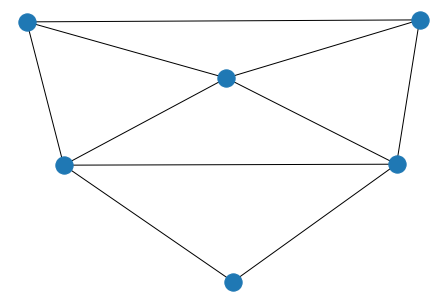

Correctly classified:  0.98779296875
Actual Synchronization: 1.0


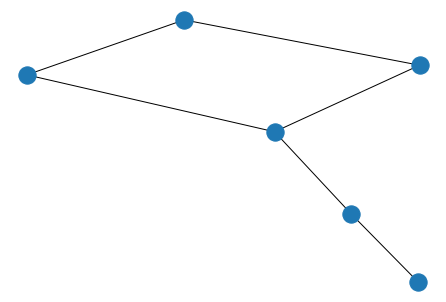

Correctly classified:  0.98779296875
Actual Synchronization: 1.0


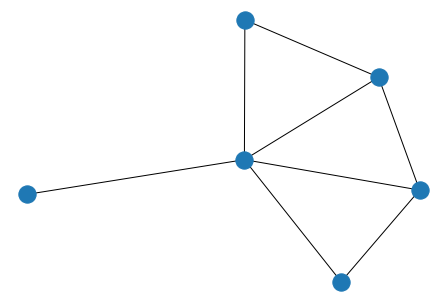

Correctly classified:  0.988037109375
Actual Synchronization: 1.0


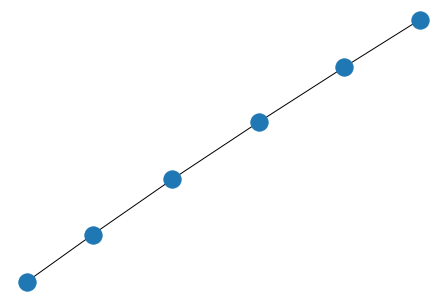

Correctly classified:  0.989990234375
Actual Synchronization: 1.0


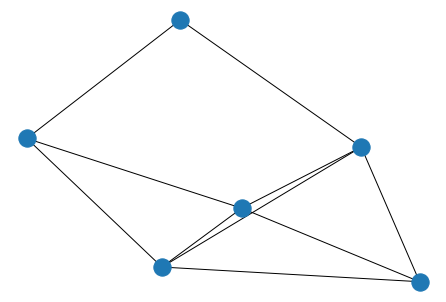

Correctly classified:  0.9912109375
Actual Synchronization: 1.0


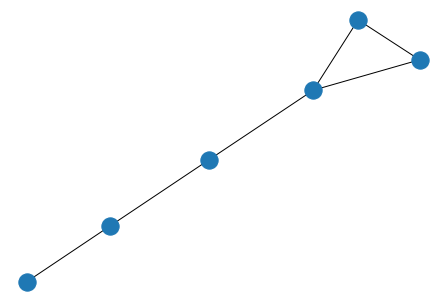

Correctly classified:  0.991455078125
Actual Synchronization: 1.0


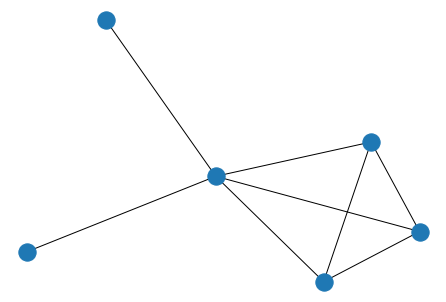

Correctly classified:  0.991943359375
Actual Synchronization: 1.0


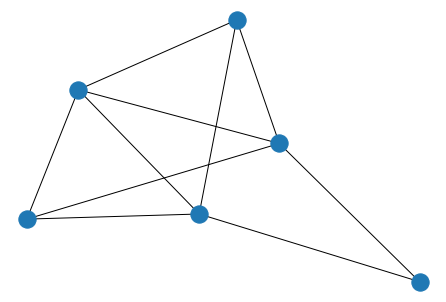

Correctly classified:  0.991943359375
Actual Synchronization: 1.0


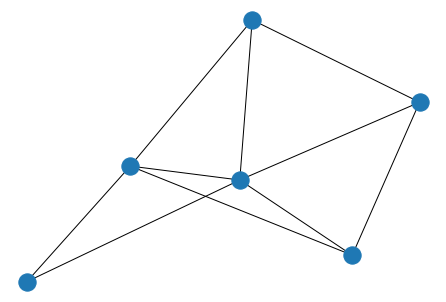

Correctly classified:  0.995849609375
Actual Synchronization: 1.0


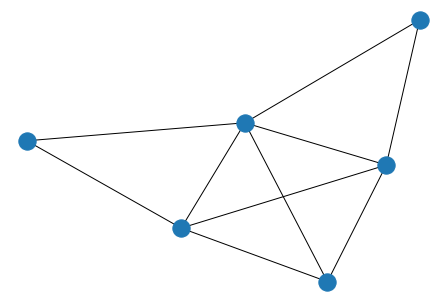

Correctly classified:  0.99658203125
Actual Synchronization: 1.0


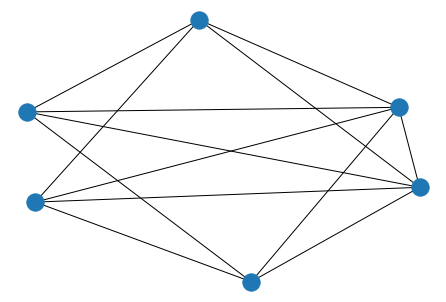

Correctly classified:  0.996826171875
Actual Synchronization: 1.0


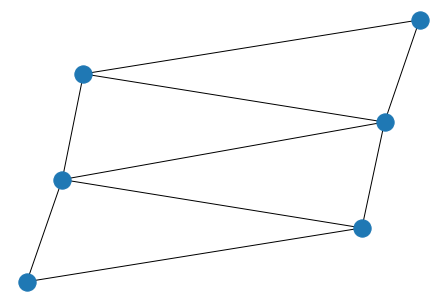

Correctly classified:  0.997802734375
Actual Synchronization: 1.0


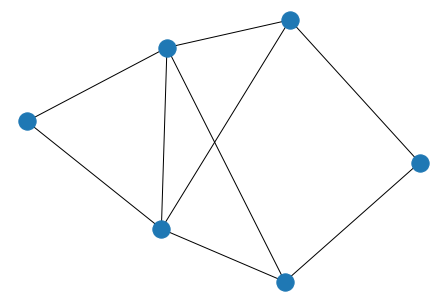

Correctly classified:  0.997802734375
Actual Synchronization: 1.0


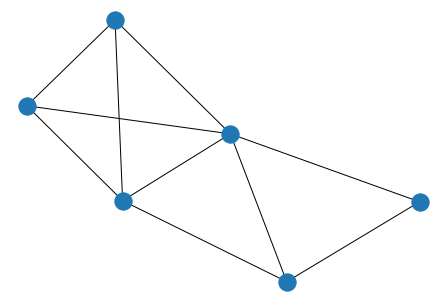

Correctly classified:  0.997802734375
Actual Synchronization: 1.0


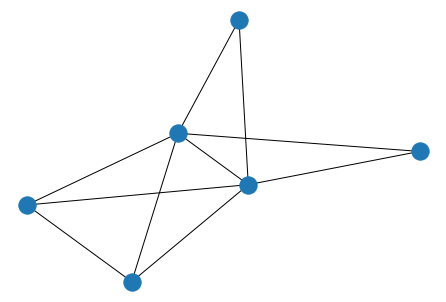

Correctly classified:  0.998291015625
Actual Synchronization: 1.0


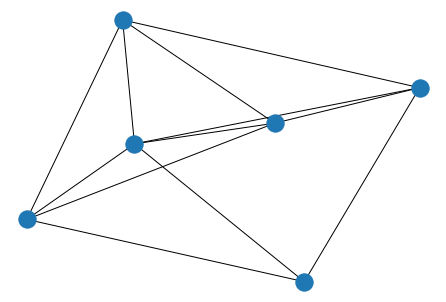

Correctly classified:  0.99951171875
Actual Synchronization: 1.0


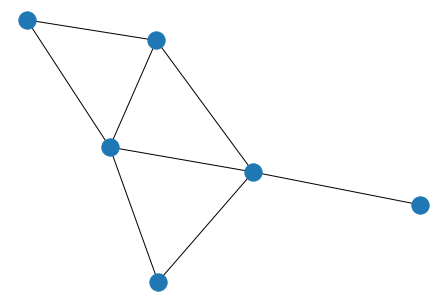

Correctly classified:  0.99951171875
Actual Synchronization: 1.0


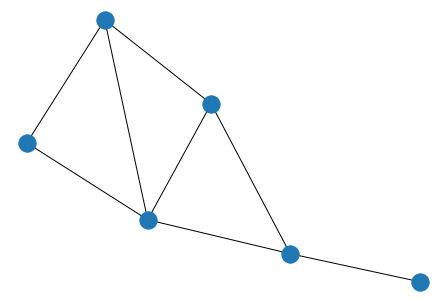

Correctly classified:  0.99951171875
Actual Synchronization: 1.0


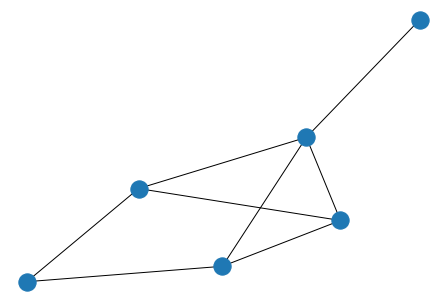

Correctly classified:  0.999755859375
Actual Synchronization: 1.0


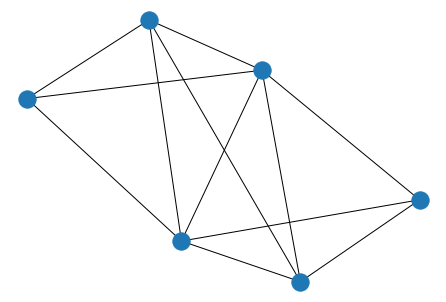

Correctly classified:  0.999755859375
Actual Synchronization: 1.0


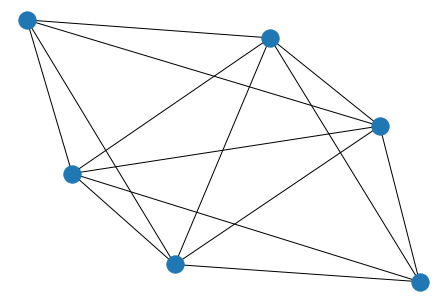

Correctly classified:  1.0
Actual Synchronization: 1.0


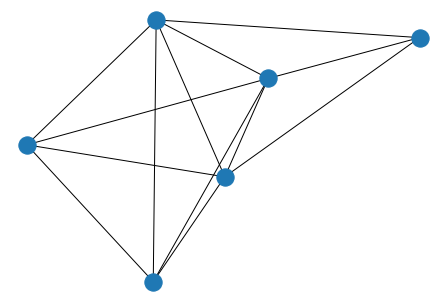

Correctly classified:  1.0
Actual Synchronization: 1.0


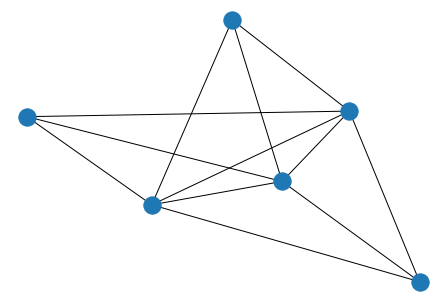

Correctly classified:  1.0
Actual Synchronization: 1.0


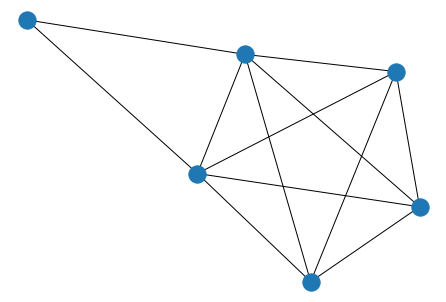

Correctly classified:  1.0
Actual Synchronization: 1.0


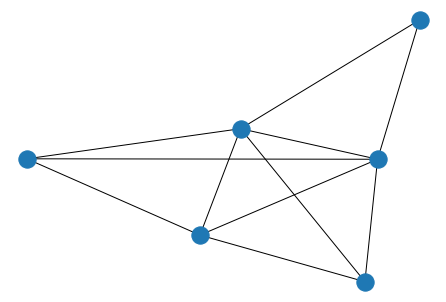

Correctly classified:  1.0
Actual Synchronization: 1.0


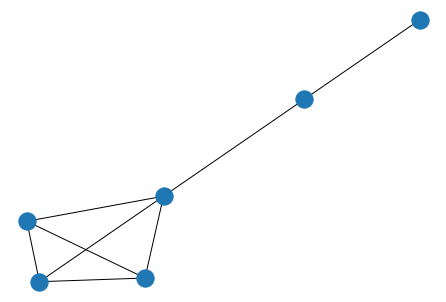

Correctly classified:  1.0
Actual Synchronization: 1.0


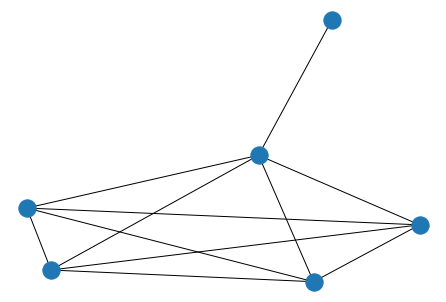

Correctly classified:  1.0
Actual Synchronization: 1.0


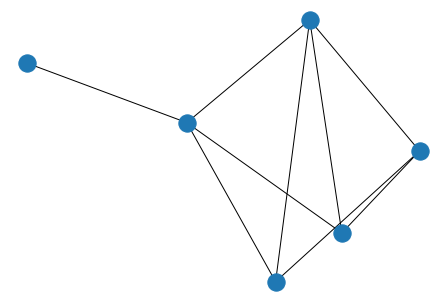

Correctly classified:  1.0
Actual Synchronization: 1.0


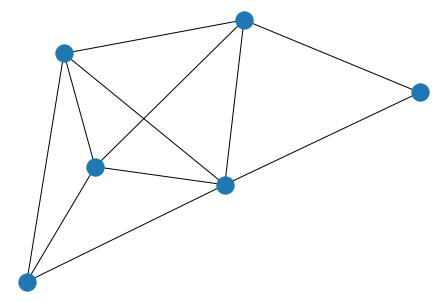

Correctly classified:  1.0
Actual Synchronization: 1.0


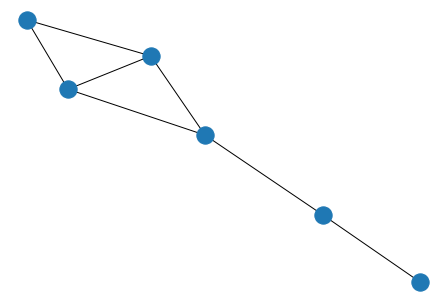

Correctly classified:  1.0
Actual Synchronization: 1.0


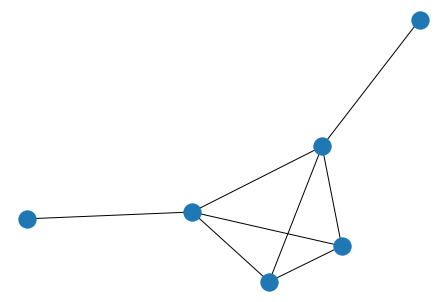

Correctly classified:  1.0
Actual Synchronization: 1.0


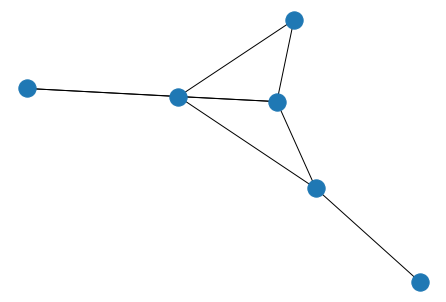

Correctly classified:  1.0
Actual Synchronization: 1.0


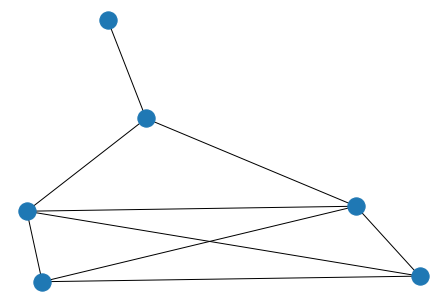

Correctly classified:  1.0
Actual Synchronization: 1.0


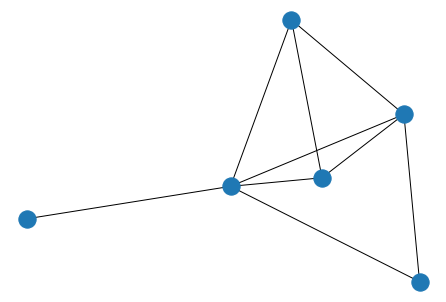

Correctly classified:  1.0
Actual Synchronization: 1.0


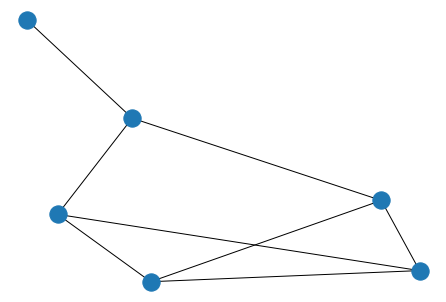

Correctly classified:  1.0
Actual Synchronization: 1.0


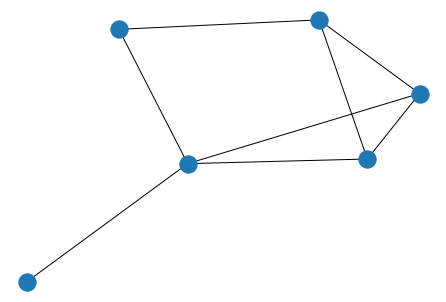

Correctly classified:  1.0
Actual Synchronization: 1.0


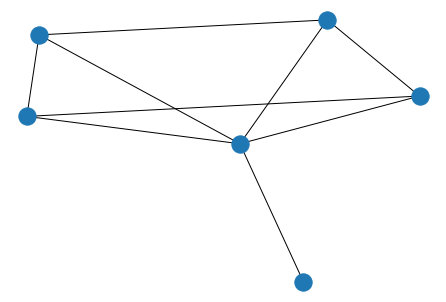

Correctly classified:  1.0
Actual Synchronization: 1.0


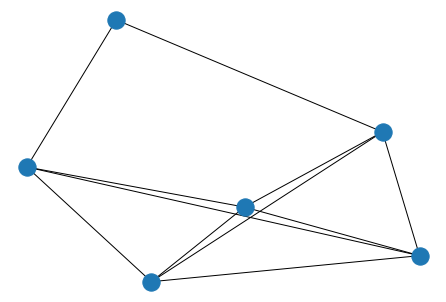

Correctly classified:  1.0
Actual Synchronization: 1.0


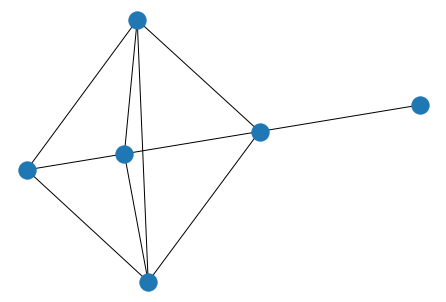

Correctly classified:  1.0
Actual Synchronization: 1.0


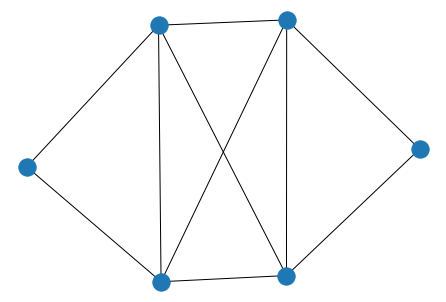

Correctly classified:  1.0
Actual Synchronization: 1.0


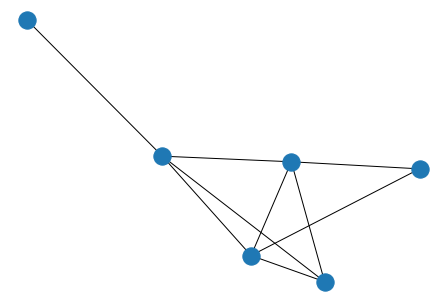

Correctly classified:  1.0
Actual Synchronization: 1.0


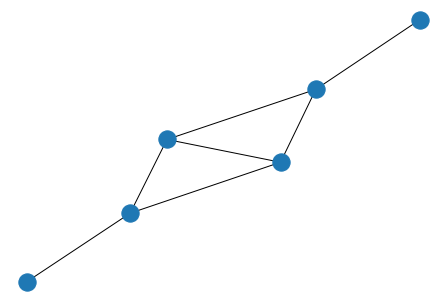

Correctly classified:  1.0
Actual Synchronization: 1.0


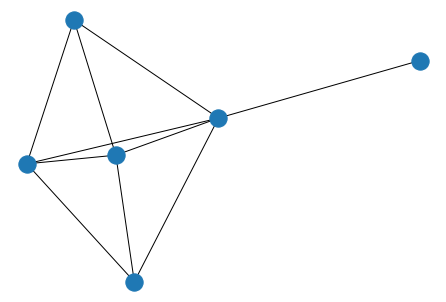

Correctly classified:  1.0
Actual Synchronization: 1.0


In [58]:
import networkx as nx
import matplotlib.pyplot as plt
for i in sort_index:
    G = nx.Graph()
    G.add_edges_from(gs[i])
    nx.draw(G)
    plt.show()
    print("Correctly classified: ", corr_pred[i]/len(color_list))
    print("Actual Synchronization:", sync_perc[i]/len(color_list))

In [ ]:
graph_adj = []
for i in gs:
    G = nx.Graph(i)
    A = nx.adjacency_matrix(G)
    graph_adj.append(A.todense())

In [70]:
G = nx.complete_graph(6)
G.edges

EdgeView([(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)])

In [3]:
import numpy as np
from tqdm import trange
import pandas as pd
import numpy as np
# from sklearn.utils.extmath import softmax
from matplotlib import pyplot as plt
import re
from tqdm import trange
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from sklearn.datasets import fetch_openml
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA

def ALS(X,
        n_components = 10, # number of columns in the dictionary matrix W
        n_iter=100,
        a0 = 0, # L1 regularizer for H
        a1 = 0, # L1 regularizer for W
        a12 = 0, # L2 regularizer for W
        H_nonnegativity=True,
        W_nonnegativity=True,
        compute_recons_error=False,
        subsample_ratio = 10):
    
        '''
        Given data matrix X, use alternating least squares to find factors W,H so that 
                                || X - WH ||_{F}^2 + a0*|H|_{1} + a1*|W|_{1} + a12 * |W|_{F}^{2}
        is minimized (at least locally)
        '''
        
        d, n = X.shape
        r = n_components
        
        #normalization = np.linalg.norm(X.reshape(-1,1),1)/np.product(X.shape) # avg entry of X
        #print('!!! avg entry of X', normalization)
        #X = X/normalization

        # Initialize factors 
        W = np.random.rand(d,r)
        H = np.random.rand(r,n) 
        # H = H * np.linalg.norm(X) / np.linalg.norm(H)
        for i in trange(n_iter):
            H = coding_within_radius(X, W.copy(), H.copy(), a1=a0, nonnegativity=H_nonnegativity, subsample_ratio=subsample_ratio)
            W = coding_within_radius(X.T, H.copy().T, W.copy().T, a1=a1, a2=a12, nonnegativity=W_nonnegativity, subsample_ratio=subsample_ratio).T
            if compute_recons_error and (i % 10 == 0) :
                print('iteration %i, reconstruction error %f' % (i, np.linalg.norm(X-W@H)**2))
        return W, H

def coding_within_radius(X, W, H0, 
                         r=None, 
                         a1=0, #L1 regularizer
                         a2=0, #L2 regularizer
                         sub_iter=[5], 
                         stopping_grad_ratio=0.0001, 
                         nonnegativity=True,
                         subsample_ratio=1):
    """
    Find \hat{H} = argmin_H ( || X - WH||_{F}^2 + a1*|H| + a2*|H|_{F}^{2} ) within radius r from H0
    Use row-wise projected gradient descent
    """
    H1 = H0.copy()
    i = 0
    dist = 1
    idx = np.arange(X.shape[1])
    if subsample_ratio>1:  # subsample columns of X and solve reduced problem (like in SGD)
        idx = np.random.randint(X.shape[1], size=X.shape[1]//subsample_ratio)
    A = W.T @ W ## Needed for gradient computation
    B = W.T @ X[:,idx]
    while (i < np.random.choice(sub_iter)):
        if_continue = np.ones(H0.shape[0])  # indexed by rows of H
        H1_old = H1.copy()
        for k in [k for k in np.arange(H0.shape[0])]:
            grad = (np.dot(A[k, :], H1[:,idx]) - B[k,:] + a1 * np.ones(len(idx))) + a2 * 2 * np.sign(H1[k,idx])
            grad_norm = np.linalg.norm(grad, 2)
            step_size = (1 / (((i + 1) ** (1)) * (A[k, k] + 1)))
            if r is not None:  # usual sparse coding without radius restriction
                d = step_size * grad_norm
                step_size = (r / max(r, d)) * step_size

            if step_size * grad_norm / np.linalg.norm(H1_old, 2) > stopping_grad_ratio:
                H1[k, idx] = H1[k, idx] - step_size * grad

            if nonnegativity:
                H1[k,idx] = np.maximum(H1[k,idx], np.zeros(shape=(len(idx),)))  # nonnegativity constraint

        i = i + 1
    return H1

def display_dictionary(W, save_name=None, score=None, grid_shape=None):
    k = int(np.sqrt(W.shape[0]))
    rows = int(np.sqrt(W.shape[1]))
    cols = int(np.sqrt(W.shape[1]))
    if grid_shape is not None:
        rows = grid_shape[0]
        cols = grid_shape[1]
    
    figsize0=(6, 6)
    if (score is None) and (grid_shape is not None):
       figsize0=(cols, rows)
    if (score is not None) and (grid_shape is not None):
       figsize0=(cols, rows+0.2)
    
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=figsize0,
                            subplot_kw={'xticks': [], 'yticks': []})
        
        
    for ax, i in zip(axs.flat, range(100)):
        if score is not None:
            idx = np.argsort(score)
            idx = np.flip(idx)    
            
            ax.imshow(W.T[idx[i]].reshape(k, k), cmap="viridis", interpolation='nearest')
            ax.set_xlabel('%1.2f' % score[i], fontsize=13)  # get the largest first
            ax.xaxis.set_label_coords(0.5, -0.05)
        else: 
            ax.imshow(W.T[i].reshape(k, k), cmap="viridis", interpolation='nearest')
            if score is not None:
                ax.set_xlabel('%1.2f' % score[i], fontsize=13)  # get the largest first
                ax.xaxis.set_label_coords(0.5, -0.05)
       
    plt.tight_layout()
    # plt.suptitle('Dictionary learned from patches of size %d' % k, fontsize=16)
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
    
    if save_name is not None:
        plt.savefig( save_name, bbox_inches='tight')
    plt.show()

  2%|▏         | 2/100 [00:00<00:08, 11.30it/s]

iteration 0, reconstruction error 74379.993248


 12%|█▏        | 12/100 [00:01<00:07, 11.47it/s]

iteration 10, reconstruction error 20772.058465


 22%|██▏       | 22/100 [00:01<00:06, 11.92it/s]

iteration 20, reconstruction error 16980.621881


 32%|███▏      | 32/100 [00:02<00:05, 12.13it/s]

iteration 30, reconstruction error 13710.655802


 42%|████▏     | 42/100 [00:03<00:04, 12.09it/s]

iteration 40, reconstruction error 11677.934145


 52%|█████▏    | 52/100 [00:04<00:03, 12.26it/s]

iteration 50, reconstruction error 10908.841400


 62%|██████▏   | 62/100 [00:05<00:03, 12.18it/s]

iteration 60, reconstruction error 10173.963591


 72%|███████▏  | 72/100 [00:06<00:02, 12.23it/s]

iteration 70, reconstruction error 9722.008245


 82%|████████▏ | 82/100 [00:06<00:01, 12.22it/s]

iteration 80, reconstruction error 9628.764288


 92%|█████████▏| 92/100 [00:07<00:00, 10.45it/s]

iteration 90, reconstruction error 9593.644534


100%|██████████| 100/100 [00:08<00:00, 11.46it/s]


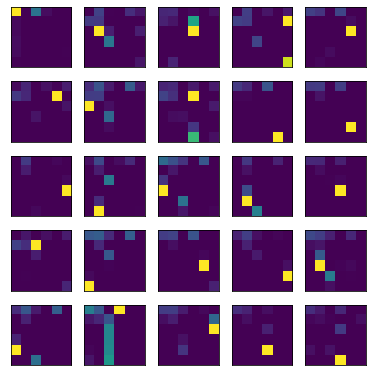

In [31]:
df=pd.read_csv("toy.csv")
df = df[df['y'] == False] 
df.drop(['baseline_width', 'y', 's5_6', 's5_5'], axis=1, inplace=True)
df = df.to_numpy().T
W, H = ALS(X=df, 
           n_components=25, 
           n_iter=100, 
           a0 = 0, # L1 regularizer for H
           a1 = 1, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity=True,
           W_nonnegativity=True,
           compute_recons_error=True,
           subsample_ratio=1)
display_dictionary(W)

  2%|▏         | 2/100 [00:00<00:14,  6.58it/s]

iteration 0, reconstruction error 45059.478040


 12%|█▏        | 12/100 [00:01<00:08, 10.64it/s]

iteration 10, reconstruction error 2576.618645


 22%|██▏       | 22/100 [00:02<00:07, 10.83it/s]

iteration 20, reconstruction error 1154.518995


 32%|███▏      | 32/100 [00:03<00:06, 11.16it/s]

iteration 30, reconstruction error 836.509935


 42%|████▏     | 42/100 [00:04<00:05, 10.99it/s]

iteration 40, reconstruction error 655.212899


 52%|█████▏    | 52/100 [00:04<00:04, 10.99it/s]

iteration 50, reconstruction error 571.738062


 62%|██████▏   | 62/100 [00:05<00:03, 11.19it/s]

iteration 60, reconstruction error 517.230632


 72%|███████▏  | 72/100 [00:06<00:02, 11.17it/s]

iteration 70, reconstruction error 476.384427


 82%|████████▏ | 82/100 [00:07<00:01,  9.37it/s]

iteration 80, reconstruction error 443.424223


 92%|█████████▏| 92/100 [00:08<00:00,  8.50it/s]

iteration 90, reconstruction error 413.359644


100%|██████████| 100/100 [00:09<00:00, 10.25it/s]


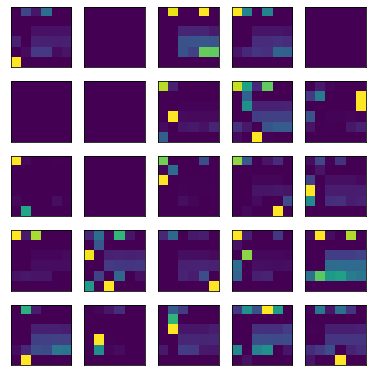

In [32]:
df=pd.read_csv("toy.csv")
df = df[df['y'] == True] 
df.drop(['baseline_width', 'y', 's5_6', 's5_5'], axis=1, inplace=True)
df = df.iloc[0:3000]
df = df.to_numpy().T
W, H = ALS(X=df, 
           n_components=25, 
           n_iter=100, 
           a0 = 0, # L1 regularizer for H
           a1 = 1, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity=True,
           W_nonnegativity=True,
           compute_recons_error=True,
           subsample_ratio=1)
display_dictionary(W)

In [35]:
from ndl import Wtd_NNetwork
G = Wtd_NNetwork()
G.load_add_edges_wtd("example.txt", use_genfromtxt=True, delimiter=",")